In [6]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [4]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [13]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_t_u, train_t_c, val_t_u, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch {}, Training Loss {}, Validation loss {}'.format(epoch, float(train_loss), float(val_loss)))

In [14]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u


In [15]:
training_loop(n_epochs = 3000,
             optimizer = optimizer,
             model = linear_model,
             loss_fn = nn.MSELoss(),
             train_t_u = train_t_un,
             train_t_c = train_t_c,
             val_t_u = val_t_un,
             val_t_c = val_t_c)

Epoch 500, Training Loss 7.387076377868652, Validation loss 13.608271598815918
Epoch 1000, Training Loss 3.59859561920166, Validation loss 7.191683292388916
Epoch 1500, Training Loss 2.952754020690918, Validation loss 5.303672790527344
Epoch 2000, Training Loss 2.8426547050476074, Validation loss 4.6539306640625
Epoch 2500, Training Loss 2.8238842487335205, Validation loss 4.407798767089844
Epoch 3000, Training Loss 2.8206868171691895, Validation loss 4.309947490692139


# Neural Network

In [16]:
seq_model = nn.Sequential(
                nn.Linear(1, 13),
                nn.Tanh(),
                nn.Linear(13, 1)
                )

In [17]:
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [18]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

In [20]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    train_t_u = train_t_un,
    train_t_c = train_t_c,
    val_t_u = val_t_un,
    val_t_c = val_t_c
)

Epoch 500, Training Loss 8.170125007629395, Validation loss 5.923606872558594
Epoch 1000, Training Loss 4.040098190307617, Validation loss 3.7990736961364746
Epoch 1500, Training Loss 4.893405914306641, Validation loss 0.4283071756362915
Epoch 2000, Training Loss 3.5597360134124756, Validation loss 0.7125769853591919
Epoch 2500, Training Loss 2.8449409008026123, Validation loss 0.9644827842712402
Epoch 3000, Training Loss 2.4387691020965576, Validation loss 1.2004398107528687
Epoch 3500, Training Loss 2.195401668548584, Validation loss 1.4247760772705078
Epoch 4000, Training Loss 2.0510573387145996, Validation loss 1.6261701583862305
Epoch 4500, Training Loss 1.9749037027359009, Validation loss 1.7780396938323975
Epoch 5000, Training Loss 1.9328066110610962, Validation loss 1.8915446996688843


In [21]:
print('output', seq_model(val_t_un))

output tensor([[ 2.4008],
        [12.9408]], grad_fn=<AddmmBackward>)


In [22]:
print('answer', val_t_c)

answer tensor([[ 0.5000],
        [11.0000]])


In [25]:
from matplotlib import pyplot as plt

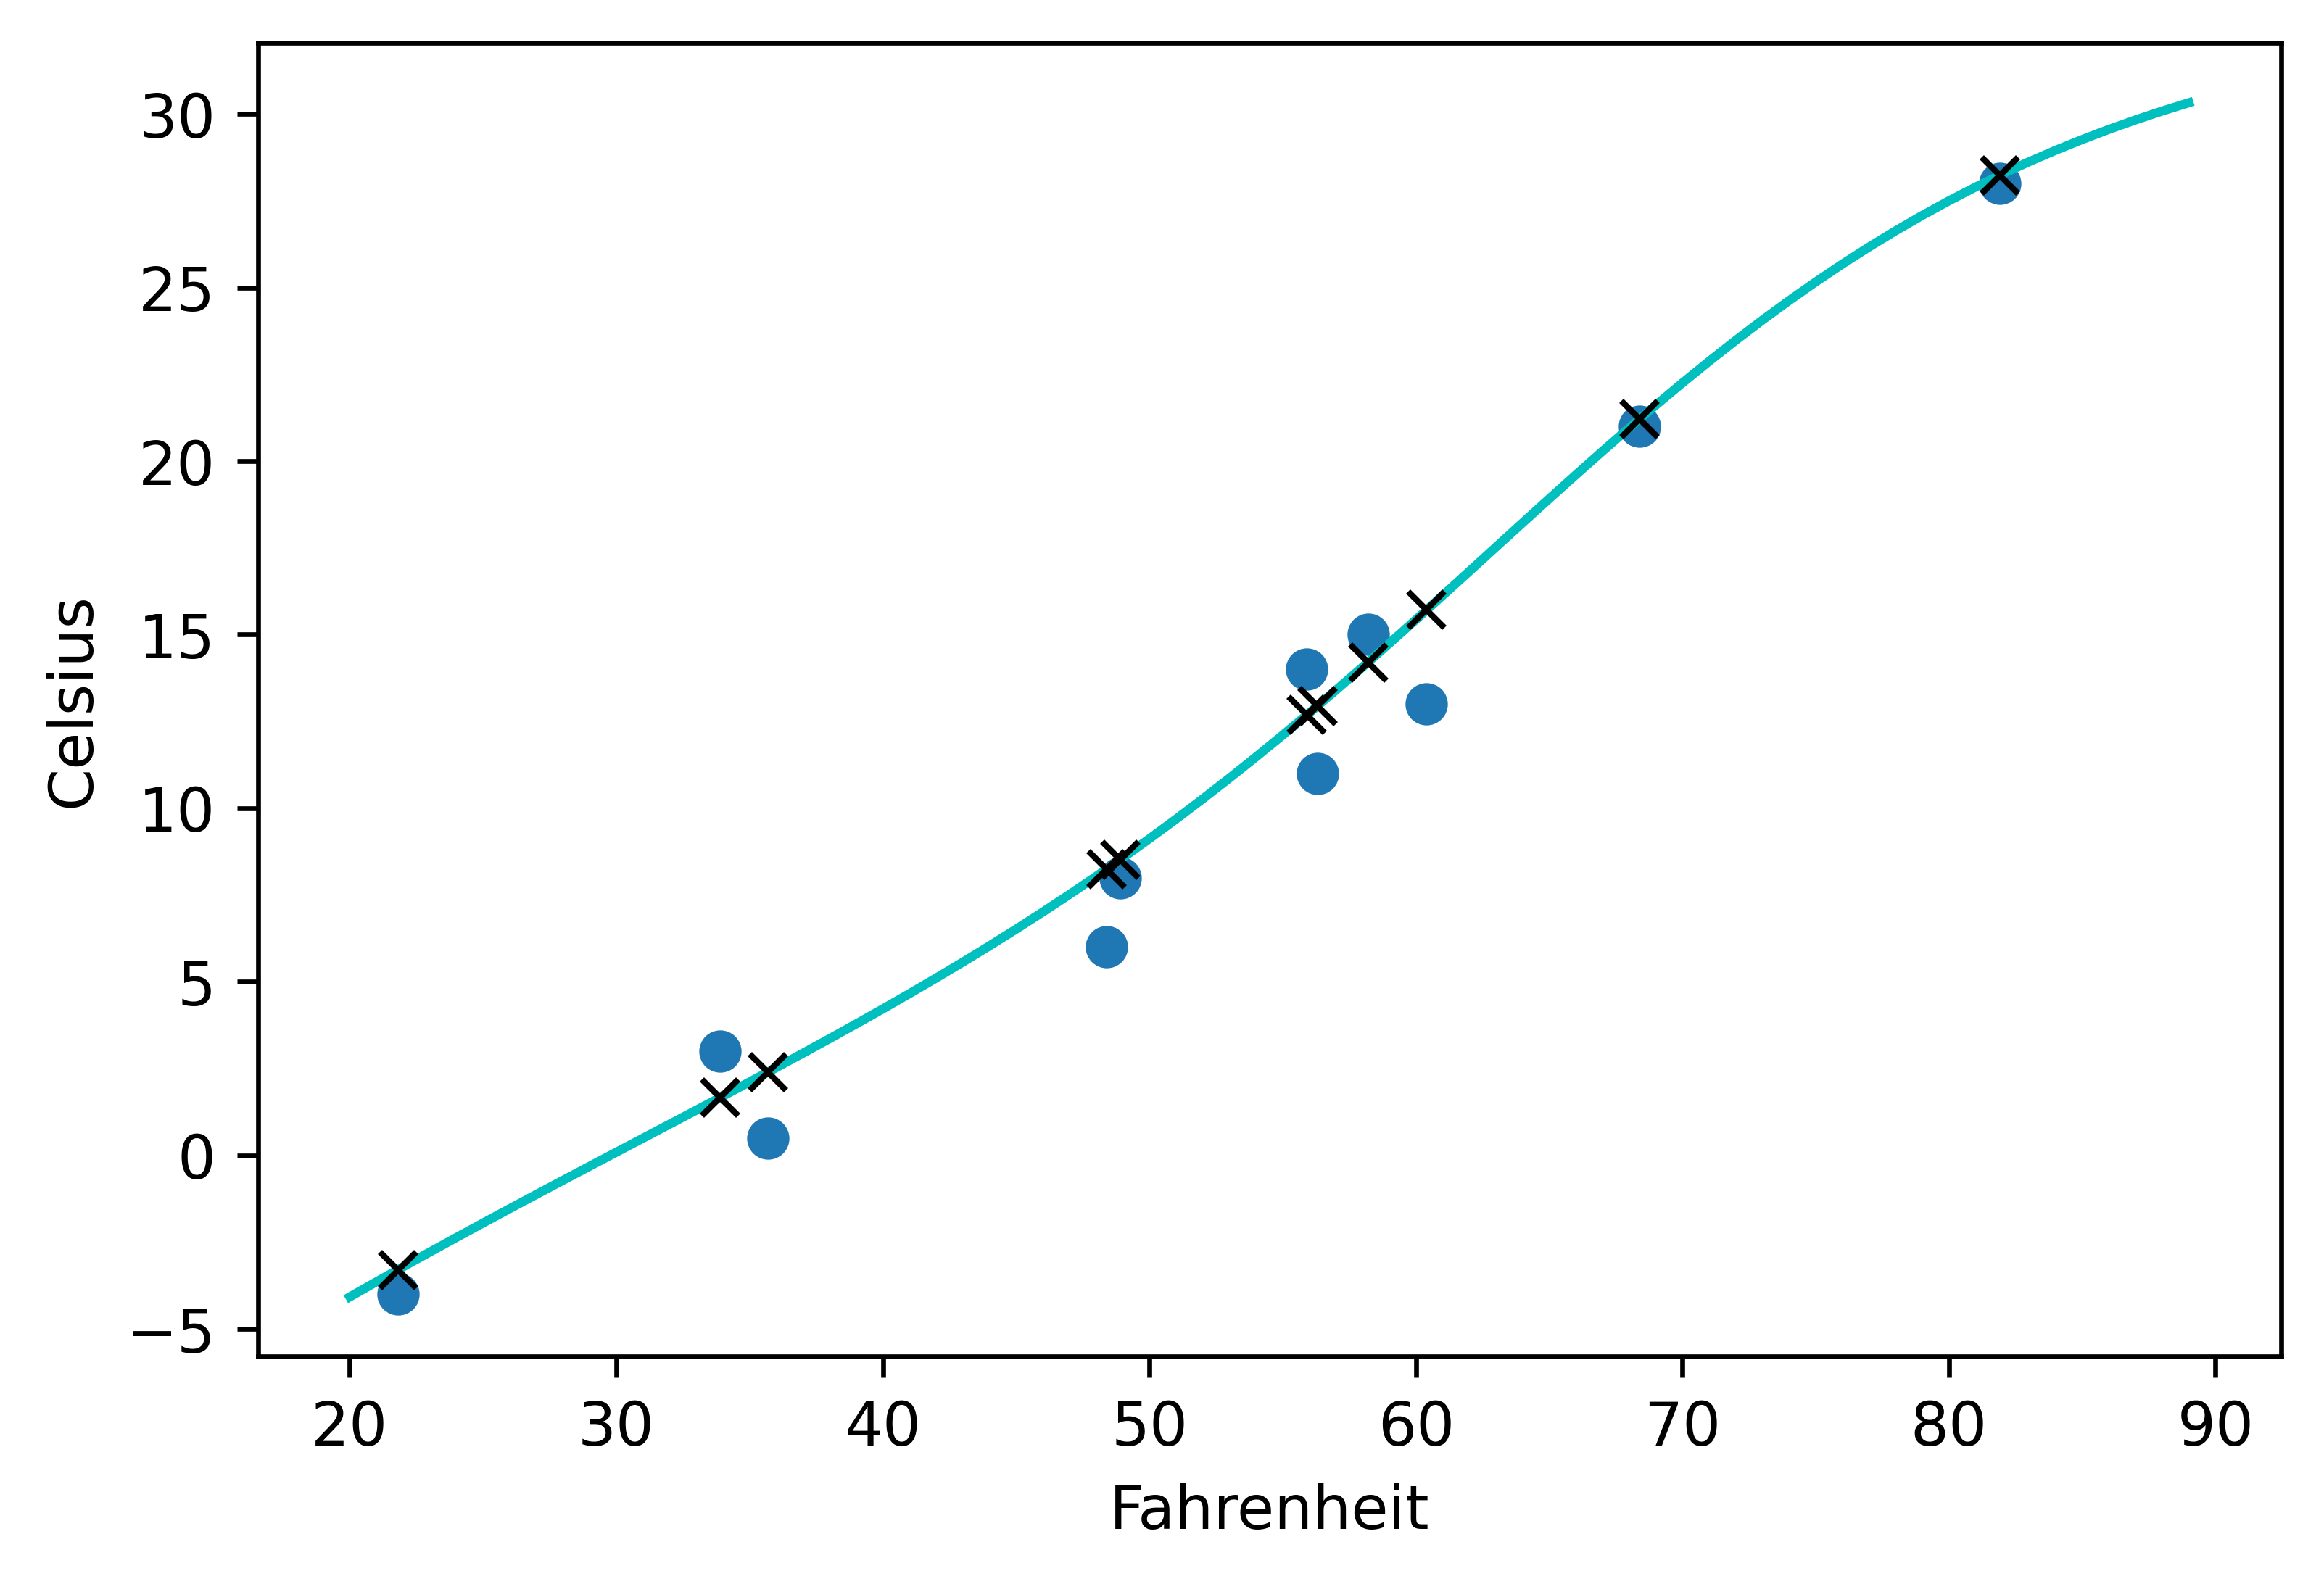

In [26]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

In [27]:
class SubclassModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 13)
        self.hidden_activation = nn.Tanh()
        self.output_linear = nn.Linear(13, 1)
        
    def forward(self, x):
        hidden_t = self.hidden_linear(x)
        activated_t = self.hidden_activation(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t
    
subclass_model = SubclassModel()
subclass_model

SubclassModel(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [28]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_linear = nn.Linear(1, 14)
        self.output_linear = nn.Linear(14, 1)
        
    def forward(self, x):
        hidden_t = self.hidden_linear(x)
        activated_t = torch.tanh(hidden_t)
        output_t = self.output_linear(activated_t)
        
        return output_t

In [29]:
func_model = SubclassFunctionalModel()
func_model

SubclassFunctionalModel(
  (hidden_linear): Linear(in_features=1, out_features=14, bias=True)
  (output_linear): Linear(in_features=14, out_features=1, bias=True)
)